# Processing a run

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylars
from pylars.plotting.plotwaveforms import *
from pylars.plotting.plotprocessed import *
from pylars.processing.waveforms import *
from pylars.processing.peaks import *
from pylars.processing.rawprocessor import *

In [3]:
# Create processor
process = pylars.processing.rawprocessor.simple_processor(sigma_level=5, baseline_samples=50)

In [4]:
#Load the raw data into the processor
data_path = '/disk/gfs_atp/xenoscope/SiPMs/char_campaign/raw_data/run6/data/BV_185K_50_00V/Module0/BV_185K_50_00V_Module_0_0.root'
process.load_raw_data(data_path, 50.0,185, module = 0)

In [5]:
process.raw_data.channels

['wf0', 'wf2', 'wf3', 'wf4', 'wf5', 'wf6']

### Take a look at waveforms

In [14]:
channel_data = process.raw_data.get_channel_data('wf0')
print(f'Found {len(channel_data)} waveforms.')

Found 50000 waveforms.


In [12]:
np.shape(channel_data)

(50000, 700)

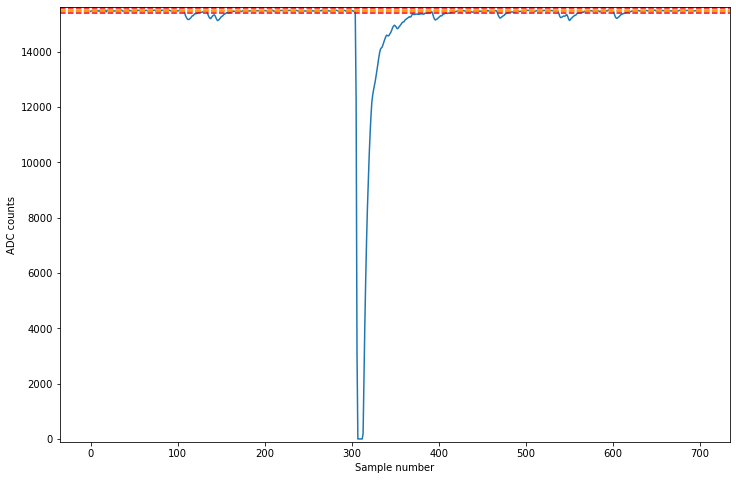

In [33]:
fig, ax = plt.subplots(1,1,figsize = (12,8))
ax = plot_waveform(channel_data[49999], ax = ax)
plt.show()

### Process by hand

In [20]:
_waveform = np.array(channel_data[7])

baseline = waveform_processing.get_baseline_rough(_waveform, 50) 
std = waveform_processing.get_std_rough(_waveform, 50)
pks = peak_processing.find_peaks_simple(_waveform, baseline, std, 5)

In [21]:
baseline

15490.0

In [22]:
std

12.043736961591282

In [23]:
pks

[array([305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
        318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
        331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
        344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
        357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
        370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
        383, 384, 385, 386, 387, 388]),
 array([392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
        405, 406, 407, 408, 409, 410, 411, 412]),
 array([416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        429, 430]),
 array([447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
        460, 461, 462, 463, 464, 465, 466])]

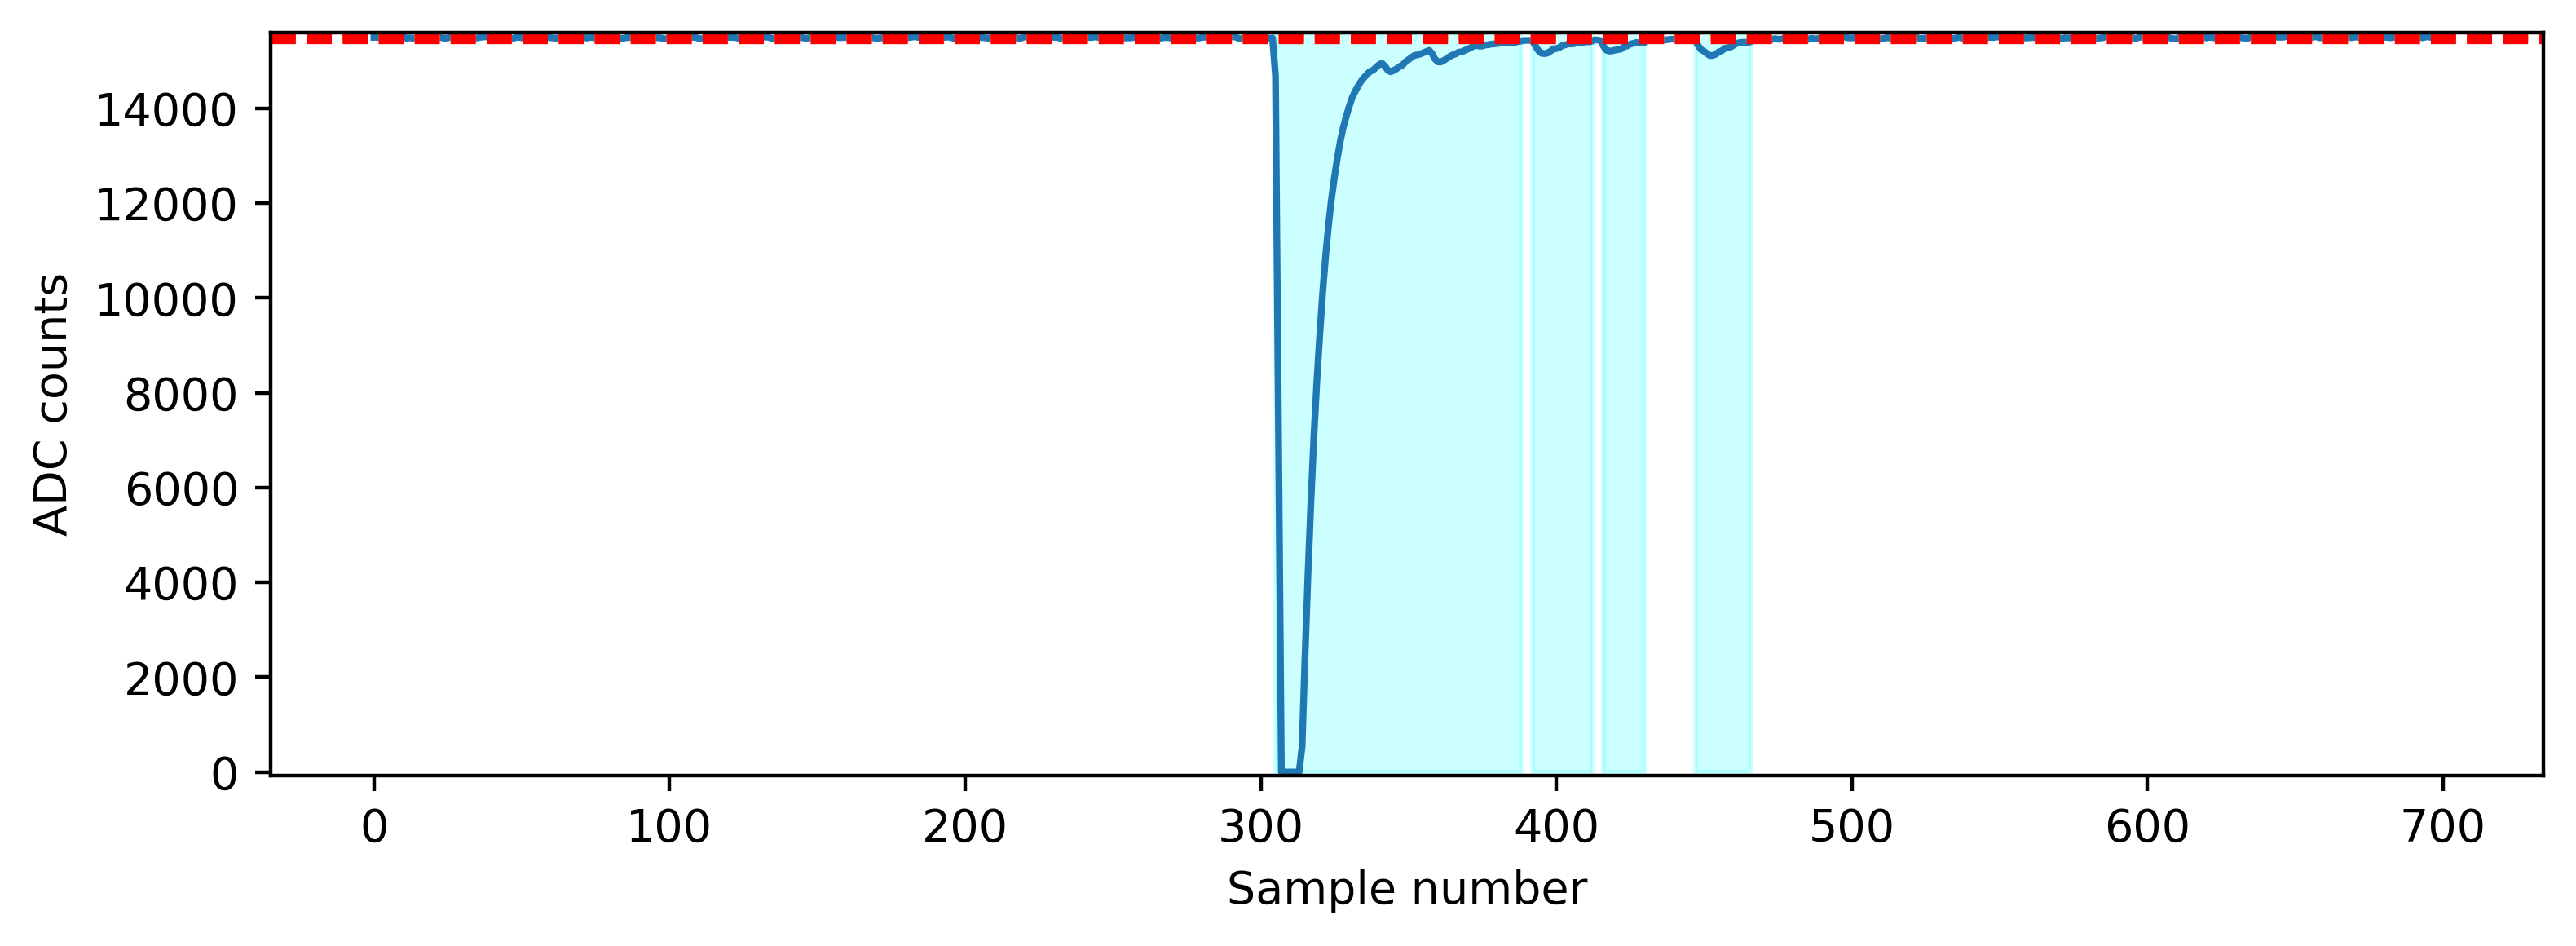

In [24]:
fig, ax = plt.subplots(1,1, figsize = (8,3), dpi = 400)
ax = plot_waveform(_waveform, ax = ax)
for pk in pks:
    if len(pk)>1:
        ax.fill_betweenx(y = np.linspace(0,16000,100), x1 = pk[0], x2 = pk[-1], alpha = 0.2, color = 'cyan')
plt.savefig('waveform1.png')
plt.tight_layout()
plt.show()

In [26]:
areas, lengths, positions, amplitudes = waveform_processing.process_waveform(np.array(channel_data[7]), process.baseline_samples, process.sigma_level)

In [27]:
areas

array([2422780.,   36570.,   26910.,   40890.])

In [29]:
amplitudes

array([    0., 15154., 15207., 15112.])

### Full channel

In [30]:
resutls_ch0 = process.process_channel('wf0')

Processing module 0 channel wf0: 100%|██████████| 50000/50000 [00:04<00:00, 10208.97it/s]


In [31]:
results_ch0 = pd.DataFrame(resutls_ch0)

In [32]:
results_ch0

,module,channel,wf_number,peak_number,area,length,position,amplitude
0,0,wf0,0,0,2661080.0,85,305,0.0
1,0,wf0,0,1,0.0,1,394,15483.5
2,0,wf0,0,2,1880.0,3,397,15384.0
3,0,wf0,0,3,25350.0,15,436,15194.0
4,0,wf0,1,0,20910.0,13,142,15221.0
...,...,...,...,...,...,...,...,...
264041,0,wf0,49999,3,36165.0,20,393,15151.0
264042,0,wf0,49999,4,18305.0,10,468,15224.0
264043,0,wf0,49999,5,45675.0,22,538,15136.0
264044,0,wf0,49999,6,895.0,2,561,15401.0


array([<AxesSubplot:xlabel='Area [integrated ADC counts]', ylabel='# events'>,
       <AxesSubplot:xlabel='Length [# samples]', ylabel='# events'>,
       <AxesSubplot:xlabel='Position [sample #]', ylabel='# events'>],
      dtype=object)

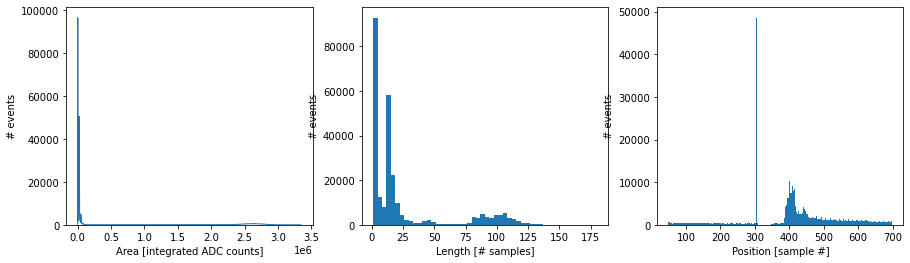

In [34]:
plot_3hists(results_ch0)

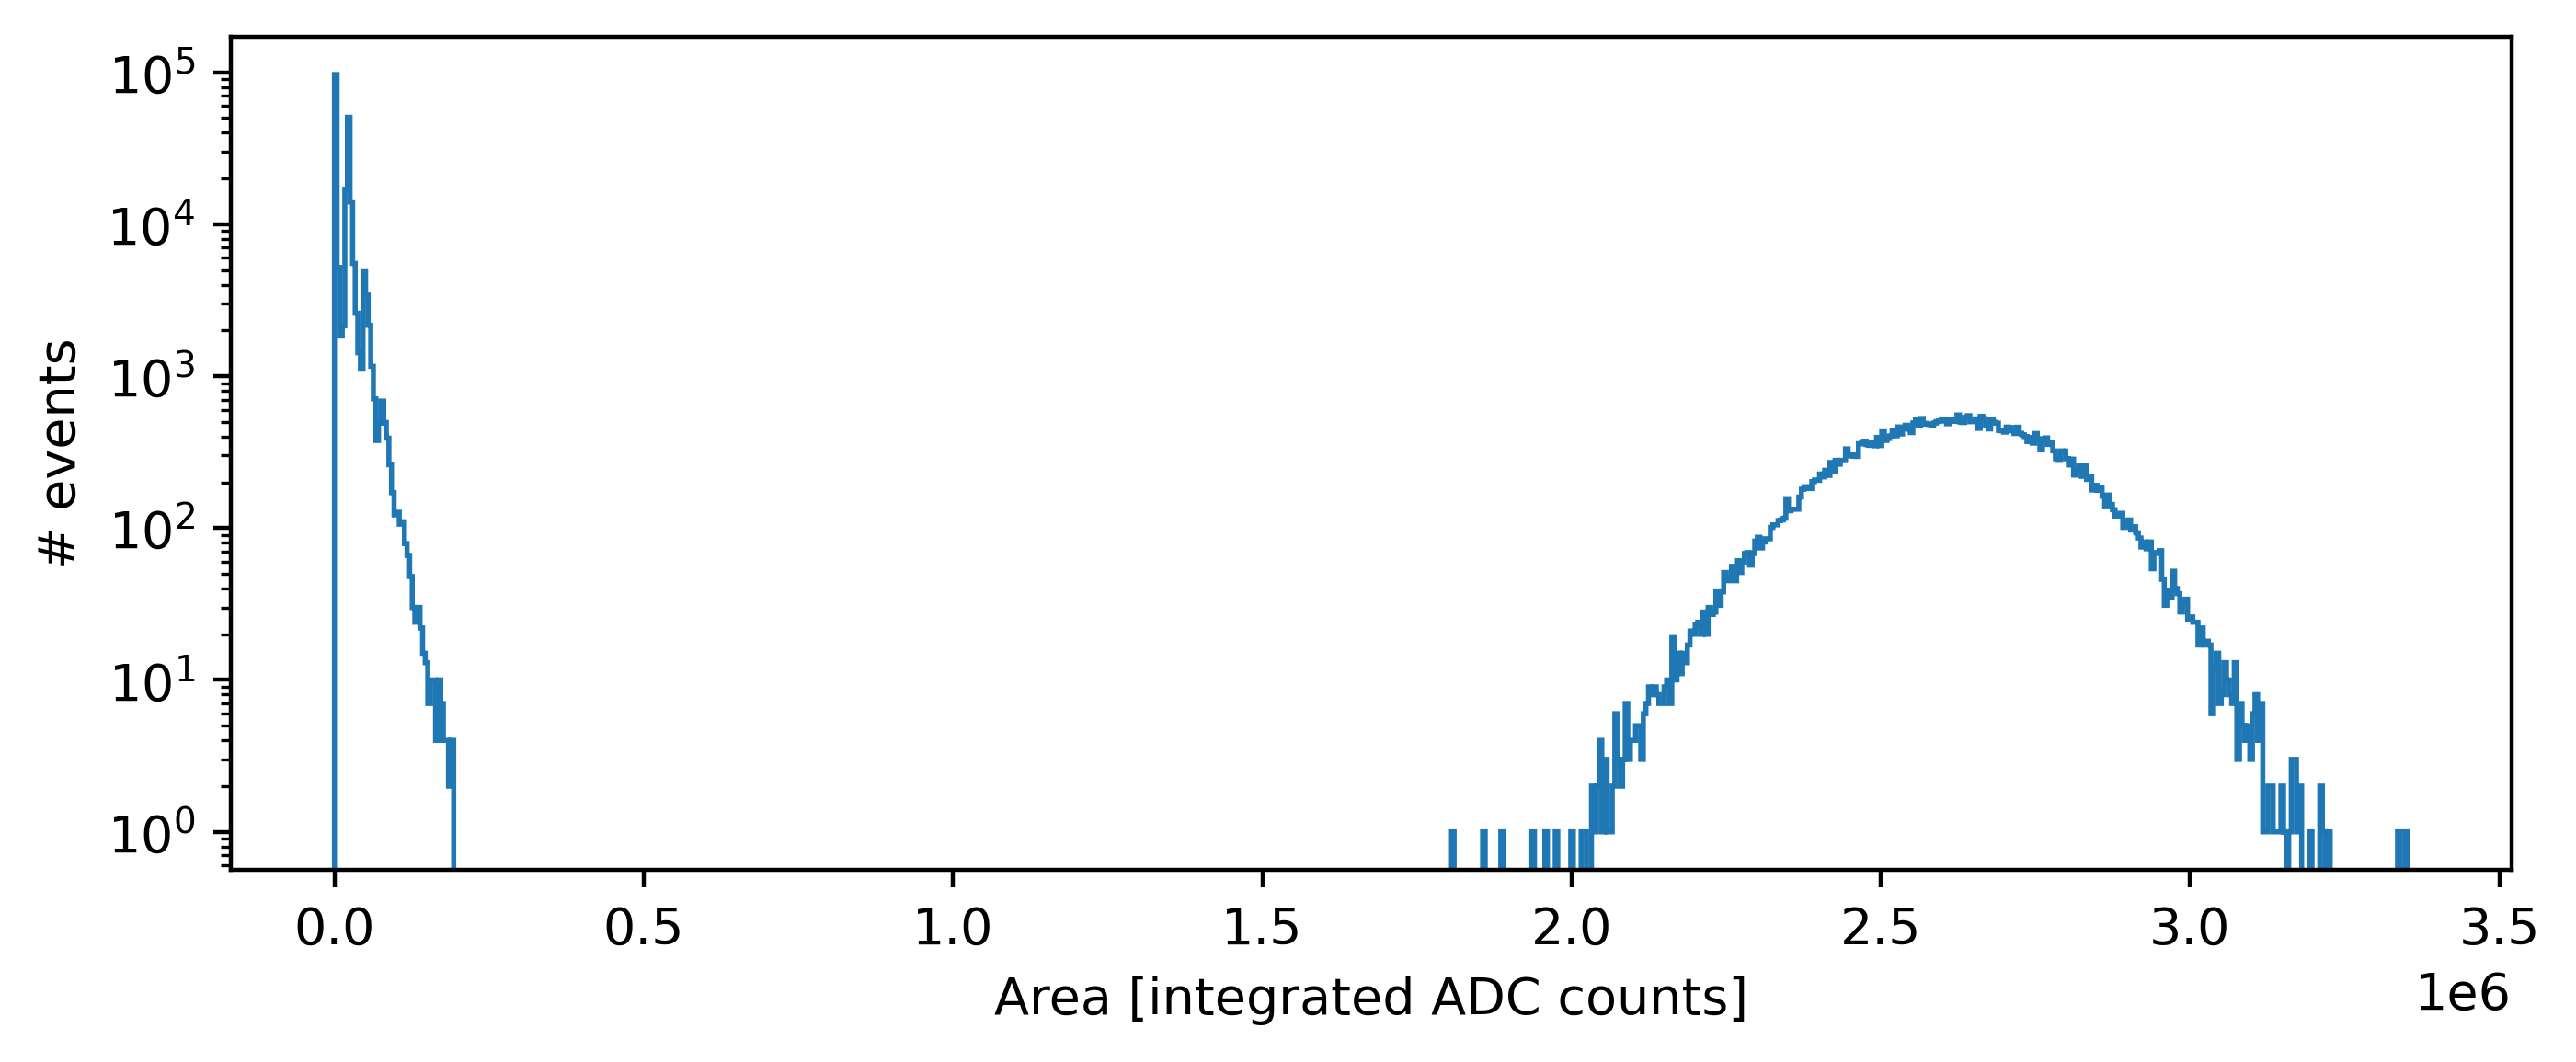

In [36]:
fig, ax = plt.subplots(1,1, figsize = (8,3), dpi = 400)
ax = plot_hist_area(results_ch0,ax = ax)

ax.set_yscale('log')
plt.show()

In [40]:
cut_mask = ((results_ch0['length'] > 7) &
            (results_ch0['length'] < 30) &
            (results_ch0['area'] < 0.5e6)
#             (results_ch0['position'] > 280) &
#             (results_ch0['position'] < 400)
           )

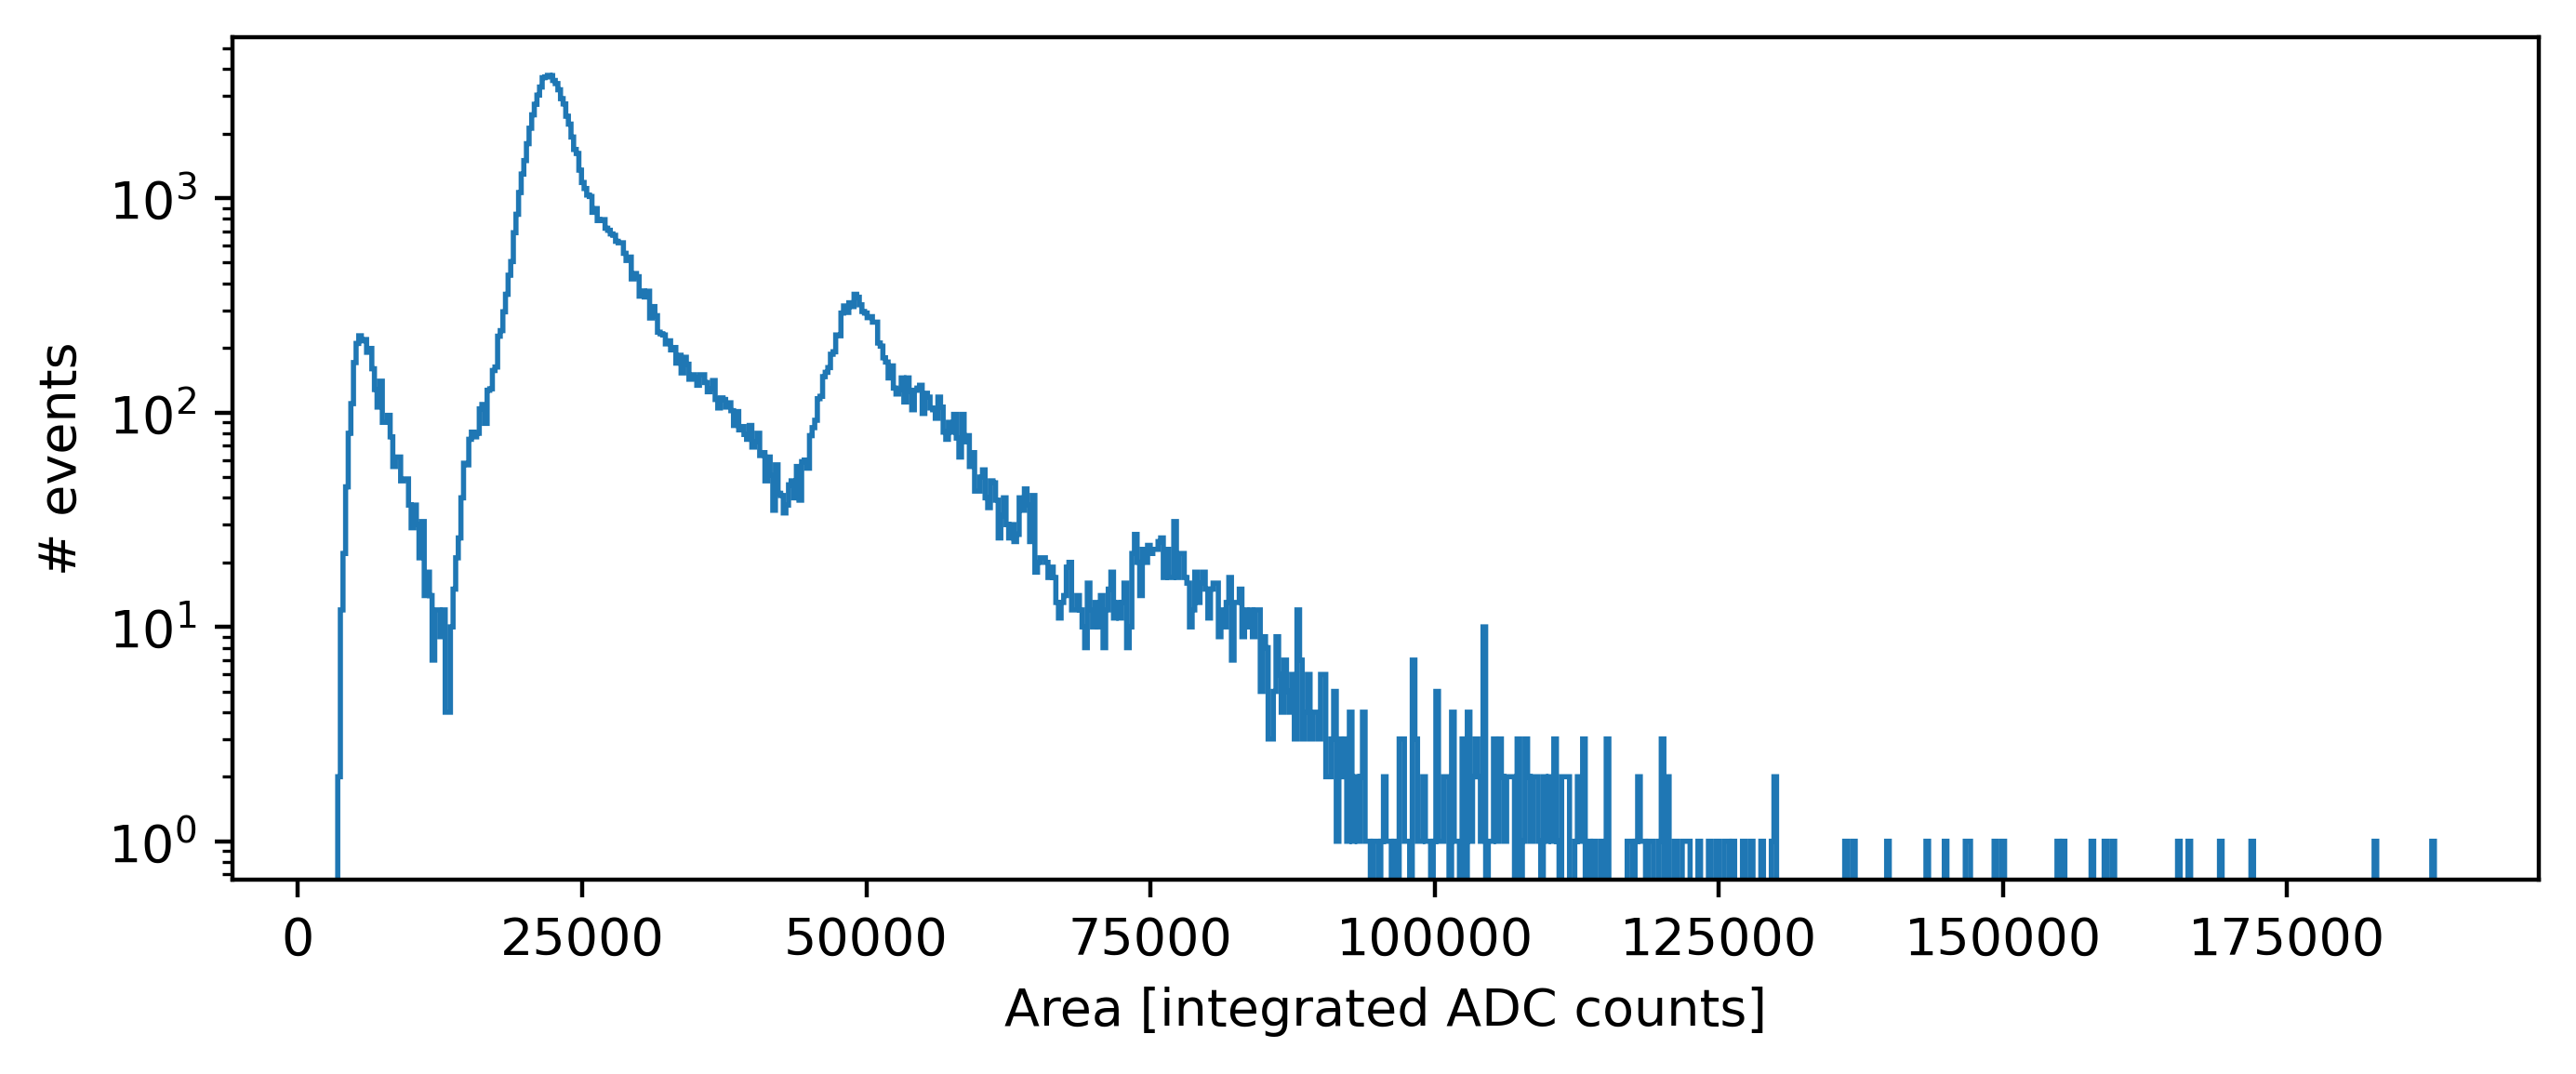

In [41]:
fig, ax = plt.subplots(1,1, figsize = (8,3), dpi = 400)
ax = plot_hist_area(results_ch0[cut_mask],ax = ax)

ax.set_yscale('log')
plt.show()